<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/Amazon_Employee_Access_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
17th, June 2023


Keep 'resource' aside while transforming features
Still get comparable results to xgboost
on full data with 'resource'

"""

In [1]:
%reset -f
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 80.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.2 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=f0d353ee9b5ab201ed53164906b3d0c1746e90c3e2c43d51a33c0f481fde003c
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph


In [2]:

# 1.0 Call libraries
import pandas as pd
import numpy as np



# 1.01
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community

# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.05
import shutil
from pathlib import Path
import itertools


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'graph_tool', 'wurlitzer', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


In [3]:
# 1.06 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(0)

In [6]:
# Read Data:
url_tr = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/train.csv"
url_te = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/test.csv"
train = pd.read_csv(url_tr)
test = pd.read_csv(url_te)   # Does not contain action columns

In [8]:
train.head(3)
test.head(3)


,action,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880


,id,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175


In [9]:
train.shape     # (32769, 10)
test.shape      # (58921, 10)


(32769, 10)

(58921, 10)

Index(['action', 'resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo',
       'roledeptname', 'roletitle', 'rolefamilydesc', 'rolefamily',
       'rolecode'],
      dtype='object')

In [10]:
train.columns

Index(['action', 'resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo',
       'roledeptname', 'roletitle', 'rolefamilydesc', 'rolefamily',
       'rolecode'],
      dtype='object')

In [11]:
y = train.pop("action")
_= test.pop("id")


0            1
1            2
2            3
3            4
4            5
         ...  
58916    58917
58917    58918
58918    58919
58919    58920
58920    58921
Name: id, Length: 58921, dtype: int64

In [12]:
# Is data balanced? No.
y.value_counts()
y.value_counts(normalize = True)  # 95%:6%


1    30872
0     1897
Name: action, dtype: int64

1    0.94211
0    0.05789
Name: action, dtype: float64

In [14]:
# Check nulls. None.
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

In [15]:
## Developing models
X_train, X_test, y_train,y_test = train_test_split(train,
                                                   y,
                                                   test_size=0.25,
                                                   stratify=y,
                                                   random_state=rng)

In [20]:
X_train.shape  #  (24576, 9)
X_test.shape   #  (8193, 9)
y_train.shape  # (24576,)
y_test.shape   # (8193,)



(24576, 9)

(8193, 9)

(24576,)

(8193,)

In [30]:
# No of unique values in columns:

for i in train.columns:
  print(f"No of unique values in '{i}' are:           \t\t{train[i].nunique()}")

No of unique values in 'resource' are:           		7518
No of unique values in 'mgrid' are:           		4243
No of unique values in 'rolerollupOne' are:           		128
No of unique values in 'rolerolluptwo' are:           		177
No of unique values in 'roledeptname' are:           		449
No of unique values in 'roletitle' are:           		343
No of unique values in 'rolefamilydesc' are:           		2358
No of unique values in 'rolefamily' are:           		67
No of unique values in 'rolecode' are:           		343


In [21]:
# Which are our cat columns?
# We will consider for transformation
# all columns but 'resource'

cat_cols = ['mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']

len(cat_cols)  # 8. 'resource' is not included

# Keep interacting columns an empty list
interactingCatCols = []


8

In [ ]:
# 5.0 Instantiate CatEncodersFamily class. We will also save
#     graphs created:
#     Folder  /content/allmodels/models created to deposit cat encoder models and graph related files

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,0,None,1,1],
                       saveGraph = True,
                       k = 40
                       )

# 5.1 Fit it using only train_dataset.
#     While fitting, 'target' is not needed.
#     Takes time...

ct.fit(X_train, cat_cols, interactingCatCols)

In [45]:
import pathlib
import pickle
def savePythonObject(pythonObject, filename, filePath = None ):

    """
    Saves any python object to disk
    File is saved to filePath. Restore it
    using restorePythonObject()
    Parameters
    ----------
    filename : pickle file for dumping
    Returns
    -------
    None.
    """
    # Current dir is the default filePath
    if filePath is None:
        filePath = pathlib.Path.cwd()
        path = filePath / filename
    else:
        path = pathlib.Path(filePath) / filename
    with open(path, 'wb') as outp:
        pickle.dump(pythonObject, outp, pickle.HIGHEST_PROTOCOL)
    print("Object saved to:", str(path))


 # It restores an earlier saved python object
def restorePythonObject(filename, filePath = None):
     """
     Called by: None
     Calls: None
     Restores an earlier saved python object
     in pickle format by savePythonObject()
     Parameters
     ----------
     filename : Pickle file having python-object
     filePath : Folder where filename is placed
                Default is modelsPath

     Returns
     -------
     Python-object

     """
     if filePath is None:
        filePath = pathlib.Path.cwd()
        path = filePath / filename
        print(f"Looking for '{filename}' in folder: {str(filePath)}" )
     else:
        path = pathlib.Path(filePath) / filename

     with open(path, 'rb') as inp:
         ct = pickle.load(inp)
     return ct



In [38]:
savePythonObject(ct, "transformer.pkl")

Object saved to: /content/transformer.pkl


In [46]:
xx = restorePythonObject("transformer.pkl")

Looking for 'transformer.pkl' in folder: /content


In [32]:
utils.savePythonObject(ct, "transformer.pkl")

PosixPath('/content/allmodels/models')

May take time if number of nodes are large


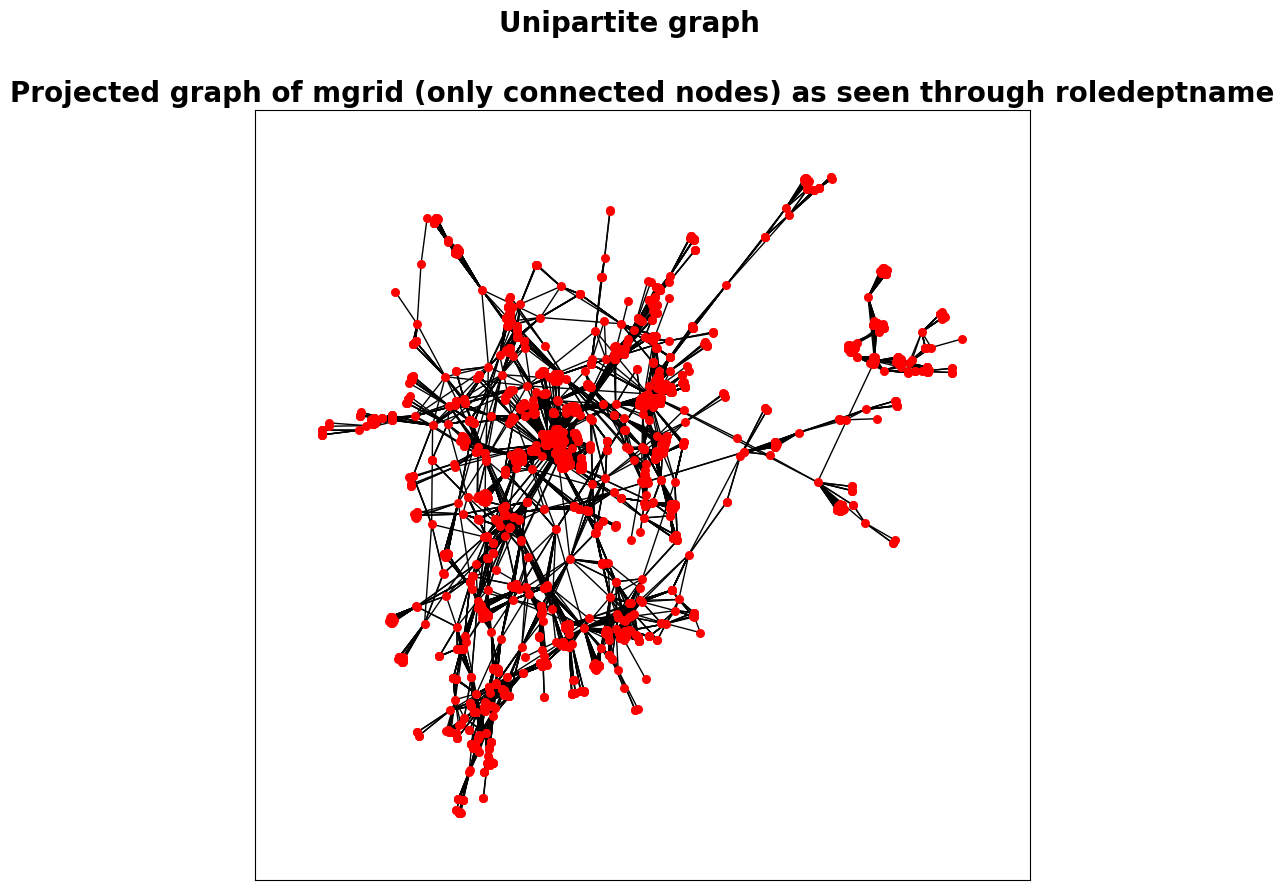

In [47]:
ct.modelsPath
ct.plotNetworkGraph("mgrid_projected_roledeptname.gml",
                    figsize = (10,10),
                    connected_nodes = True
                    )


## Data transformation:

In [48]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(X_test[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  224
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 14.354136 MB
Mem usage after dtype transformation is: 7.472016 MB


'Transformed test data shape: (8193, 218)'

In [49]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(X_train[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  224
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 43.057152 MB
Mem usage after dtype transformation is: 22.413312 MB


'Transformed train data shape: (24576, 218)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [50]:
# 6.1 Observe data now:
#     It also has original binned cols (6):

train_trans.head()
test_trans.head()

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,49850,117961,118413,122007,132671,118260,290919,132673,0.422278,2.433940e-02,...,0.003182,0.000058,0.047815,0.018182,0.055752,0.002328,0.000029,0.030303,2.584054e-18,0.003125
1,31941,117916,118011,118599,179731,258199,117887,117973,0.021527,-1.010946e-17,...,0.010882,0.059794,0.083709,0.096970,0.212152,0.011906,0.043105,0.039394,3.949833e-18,0.003125
2,10704,117932,117933,117878,117879,288294,19721,117880,0.006258,5.021726e-18,...,0.003381,0.002261,-0.054794,0.090909,0.117332,0.012748,0.040742,0.036364,-6.621317e-17,0.003125
3,4588,117961,118225,118403,117905,117906,290919,117908,0.422278,2.433940e-02,...,0.013900,0.042144,-0.015905,0.072727,0.191312,0.008338,0.023316,0.030303,9.806478e-18,0.003125
4,196,117961,118413,121639,129909,130134,118453,129911,0.422278,2.433940e-02,...,0.002294,0.000234,-0.029621,0.030303,0.036484,0.004569,0.002825,0.012121,-1.148705e-17,0.003125


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,20496,118219,118220,117912,118568,136473,19721,118570,0.010263,2.676210e-08,...,0.004155,0.005124,0.080893,0.087879,0.099389,0.012786,0.037832,0.036364,-5.415797e-17,0.003125
1,5313,117961,118386,120356,120357,201020,118424,120359,0.422278,2.433940e-02,...,0.003228,0.001115,0.039907,0.021212,0.005346,0.004058,0.000979,0.075758,1.961161e-01,0.003125
2,1549,118084,118085,117920,118568,310732,19721,118570,0.008010,8.759089e-09,...,0.004155,0.005124,0.080893,0.087879,0.099389,0.012786,0.037832,0.036364,-5.415797e-17,0.003125
3,56781,117926,118266,117941,117879,117886,19721,117880,0.015519,7.077882e-18,...,0.003381,0.002261,-0.054794,0.090909,0.117332,0.012748,0.040742,0.036364,-6.621317e-17,0.003125
4,23347,117961,118052,119408,118777,279443,308574,118779,0.422278,2.433940e-02,...,0.014775,0.059659,-0.071386,0.075758,0.122366,0.009251,0.024647,0.009091,1.048446e-17,0.003125


In [62]:
train_trans.shape   #   (24576, 218)
test_trans.shape    #  (8193, 218)

(24576, 218)

(8193, 218)

## Make an archive of files in gdrive
This is for later use


In [51]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Archive of graph files to gdrive

In [53]:
# 6.2.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/allmodels/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [54]:
# 6.3 Archive folder where graph files are stored to gdrive
output_filename = outputfolder / "models"
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(output_filename) +".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/allmodels/models.zip'

In [55]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = Path(r'/gdrive/MyDrive/Colab_data_files/allmodels/models').glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/rolefamily_projected_rolefamilydesc.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/rolecode_bigraph_roledeptname.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/rolerolluptwo_projected_roledeptname.gml')]

### Archive of datafiles

In [57]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)


# Full file paths:
# Our train/test data
trfile = destination / "X_train.pkl"
tefile = destination / "X_test.pkl"
ytr = destination / "y_train.pkl"
yte = destination / 'y_test.pkl'

# Our transformed data
trtrans = destination / 'train_trans.pkl'
tetrans = destination / 'test_trans.pkl'

# Our fitted class object
transformer = destination / "transformer.pkl"


# Now save
X_train.to_pickle(trfile)
X_test.to_pickle(tefile)
y_train.to_pickle(ytr)
y_test.to_pickle(yte)
train_trans.to_pickle(trtrans)
test_trans.to_pickle(tetrans)

In [58]:
# 6.5.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/datafiles/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [59]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
output_filename = outputfolder / "data"
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(output_filename)+".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/datafiles/data.zip'

In [60]:
# 6.7 Let us have a look at our list of pickled files:
p = Path(r'/gdrive/MyDrive/Colab_data_files/datafiles/data').glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/y_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/X_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/y_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/X_train.pkl')]

### Archive of transformer object

In [61]:
# Also copy transformer.pkl to gdrive

shutil.copy('/content/transformer.pkl', '/gdrive/MyDrive/Colab_data_files/datafiles/data/transformer.pkl')


'/gdrive/MyDrive/Colab_data_files/datafiles/data/transformer.pkl'

## Read back archive data
Should you need it

In [ ]:
train_trans = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/")
test_trans = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/")

## xgboost modeling of original data and of transformed data:

In [ ]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 500,
                           verbosity = 3,
                           eta = 0.04,
                           max_depth = 15,
                           subsample = 0.9,           # 0.8
                           random_state = rng,
                           reg_lambda = 1.5,
                            )


tr_X =   X_train
test_X = X_test
ytr = y_train
yte = y_test


model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 100,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )


In [ ]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

In [ ]:
model_trans = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.04,      # 0.06
                           max_depth = 13,
                           subsample = 0.9,           # 0.8
                           random_state = rng,
                           reg_lambda = 1.5,


                           )

## NOTE THIS IS WITHOT resource column
tr_X =  train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytrain = y_train
ytest = y_test


model_trans.fit(tr_X, ytrain.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )

### Learning curve plots

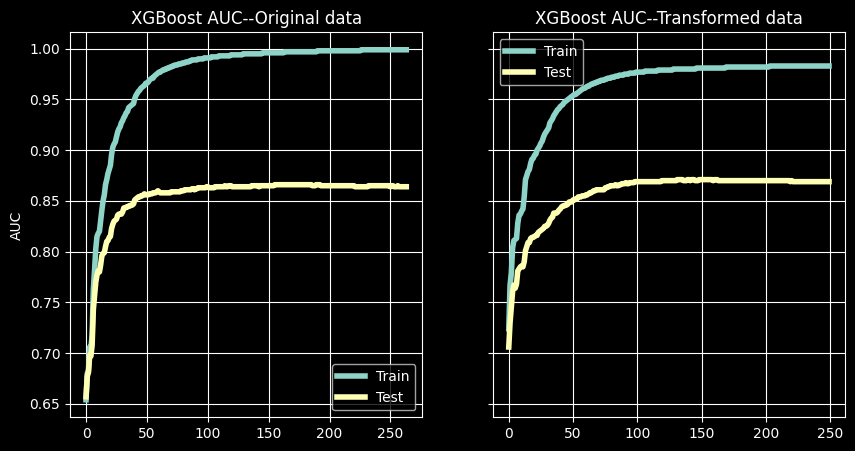

In [79]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=4, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=4, label='Test');
ax[0].legend();
ax[0].grid()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=4, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 4, label='Test');
ax[1].legend();
ax[1].grid()
ax[1].set_title('XGBoost AUC--Transformed data');
plt.show();

In [80]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.8708126366907675'

'Best iteration from transformed train/test data: 149'

### Classification reports

In [89]:
pred_orig = model_orig.predict(X_test)
pred_trans = model_trans.predict(test_X)

print("Note that the f1-score from transformed data is better than that from original data\n")
print(f"Classification report from original data: \n {classification_report(ytest,pred_orig)}")
print("\n==================\n")

print(f"Classification report from transformed data: \n {classification_report(ytest,pred_trans)}")

Note that the f1-score from transformed data is better than that from original data

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.75      0.23      0.35       474
           1       0.95      1.00      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.85      0.61      0.66      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from transformed data: 
               precision    recall  f1-score   support

           0       0.64      0.37      0.47       474
           1       0.96      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.80      0.68      0.72      8193
weighted avg       0.94      0.95      0.95      8193



## PCAs with transformed data:

In [92]:
# Check if any nulls in data
#  else we would impute using SimpleImputer:

train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # > 16800
pca_train = train_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns
pca_test  = test_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns

0

0

In [91]:
si = SimpleImputer(strategy = 'median')
pca_train[:] = si.fit_transform(pca_train)
pca_test[:] = si.transform(pca_test)

In [65]:
# 7.1 2D PCA with transformed train data.
#     Drop the initial cat_cols first:


pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
test_pca = pca.transform(ss.transform(test_))

(24576, 2)

In [67]:
# 7.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(trans_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

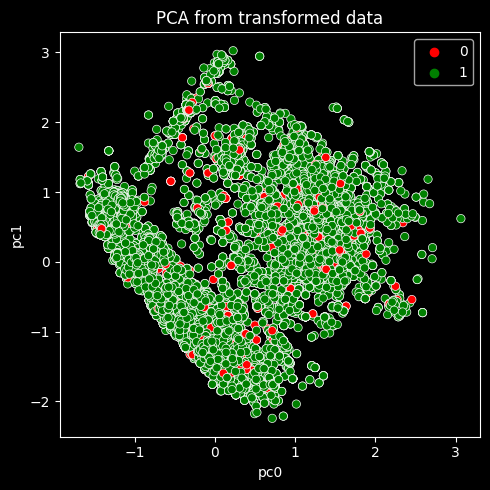

In [69]:
# 8.1 2D PCA plot from original train data:
fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
plt.style.use("dark_background");
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;



In [ ]:




##############################
## PCA
##############################
from sklearn.decomposition import PCA
#from sklearn.decomposition import KernelPCA

## 2D
# kernelpca requires huge RAM. Hangs
del pca
pca = PCA(n_components= 2, whiten= True, random_state = rng)


train_trans.columns[:9]
l=train_trans.columns[9:]
l

# Check null status and fill it up with median
da = train_trans[l]
da.isnull().sum().sum()
da.isnull().sum()[da.isnull().sum() > 0]
nullcols = list(da.isnull().sum()[da.isnull().sum() > 0].index)
nullcols
# Fill up nulls using median
for i in nullcols:
    da[i]= da[i].fillna(da[i].median())

# Check again
da.isnull().sum().sum()
da.columns
da.shape   #  (513, 192)

del ss
ss = StandardScaler()
da = pca.fit_transform(ss.fit_transform(da))
da.shape  #  (24576, 19)

colnames = ["pc" + str(i) for i in range(da.shape[1])]
colnames
da = pd.DataFrame(da, columns = colnames)
sns.scatterplot(x= da['pc0'], y = da['pc1'], hue = y_train.values)

## How good is PCA

Xtrain, Xtest, ytr,yte = train_test_split(da, y_train, test_size = 0.20, stratify=y_train)

model_pca= 0
evals_result= {}
del model_pca
model_pca = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 15,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = rng
                           )


tr_X = Xtrain # Xtrain
test_X = Xtest # Xtest
ytrain = ytr
ytest = yte


model_pca.fit(tr_X, ytrain.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, ytest.values)],
          eval_metric = ['auc']    # binary classification problem
          )



# auc: 0.81646
model_pca.best_score   # 0.80
pred = model_pca.predict(test_X)
(pred == yte).sum()/yte.size    # 0.9515440

print(classification_report(ytest.values,pred))

"""

                 precision    recall  f1-score   support

           0       0.57      0.16      0.25       288
           1       0.95      0.99      0.97      4628

    accuracy                           0.94      4916
   macro avg       0.76      0.57      0.61      4916
weighted avg       0.93      0.94      0.93      4916


"""


##############################
## tsne
##############################
# Why blobs do not appear together in tsne?
# See StackOverflow:
#    https://stats.stackexchange.com/a/453106/78454


from sklearn.manifold import  TSNE

# Not possible to tsne original data
#  being categorical

train_trans[l].head()
tsne = TSNE(perplexity = 30)  # 30 gives best AUC
                              # Tried 20 and 50
ss = StandardScaler()
da = tsne.fit_transform(ss.fit_transform(train_trans[l]))
da.shape
da
colnames = ["tsne" + str(i) for i in range(da.shape[1])]
colnames
da = pd.DataFrame(da, columns = colnames)
da.head()

plt.figure(100)
sns.scatterplot(x= da['tsne0'], y = da['tsne1'], hue = y_train.values)


Xtrain, Xtest, ytr, yte = train_test_split(da, y_train, test_size = 0.20,stratify= y_train )

evals_result= {}
model_tsne = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70
                           )


tr_X =  Xtrain
test_X = Xtest



model_tsne.fit(tr_X, ytr,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, yte)],
          eval_metric = ['auc']
          )




model_tsne.best_score   # 0.8215140479448766
pred = model_tsne.predict(test_X)
(pred == yte).sum()/yte.size    # 0.75

print(classification_report(yte,pred))

"""
auc = 0.82151

                precision    recall  f1-score   support

           0       0.70      0.19      0.30       288
           1       0.95      0.99      0.97      4628

    accuracy                           0.95      4916
   macro avg       0.83      0.59      0.64      4916
weighted avg       0.94      0.95      0.93      4916


"""


############################
# Optuna hyperparameter tuning
###########################
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.


import optuna
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')



# Get our train/test data:
# Transformed data
# Filter out initial 9
#  cat columns. Keep only their
#   numeric transformations

l=train_trans.columns[9:]
l
tr_X =  train_trans[l] # Xtrain
test_X = test_trans[l] # Xtest
ytrain = y_train
ytest = y_test

# Original data
tr_X =  X_train
test_X = X_test
ytrain = y_train
ytest = y_test



# Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 14),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'auc',
        'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 0)
    # Maximise f1-score
    return f1



# Create optuna study
study = optuna.create_study(direction='maximize')
# Begin optimization
study.optimize(objective, n_trials=400)
# Can run this function again to optimize further
study.optimize(objective, n_trials=200)


# After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)
# Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# Use these parameters in our estimator:
best_params = trial.params

model = xgb.XGBClassifier(**best_params)
model.fit(tr_X, ytrain)

# Make predictions and assessments:
y_pred = model.predict(test_X)
print(classification_report(ytest, y_pred))


"""
Results with transformed features (400 trials):
==================================

               precision    recall  f1-score   support

           0       0.57      0.43      0.49       458
           1       0.97      0.98      0.97      7735

    accuracy                           0.95      8193
   macro avg       0.77      0.70      0.73      8193
weighted avg       0.94      0.95      0.95      8193



              precision    recall  f1-score   support

           0       0.57      0.45      0.50       458
           1       0.97      0.98      0.97      7735

    accuracy                           0.95      8193
   macro avg       0.77      0.71      0.74      8193
weighted avg       0.95      0.95      0.95      8193



Results with original data (400 trials):
===========================

             precision    recall  f1-score   support

           0       0.65      0.40      0.49       458
           1       0.97      0.99      0.98      7735

    accuracy                           0.95      8193
   macro avg       0.81      0.69      0.73      8193
weighted avg       0.95      0.95      0.95      8193
"""


# Also calculate 'auc':
# If f1-score is maximised, there
#  is some slight degradaion in 'auc'
y_score = model.predict_proba(test_X)
roc_auc_score(ytest, y_score[:,1])     # 0.846096/ 0.848417700973570





############################
# Optuna hp tuning
###########################
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise auc

# Call libraries, as usuual:
import optuna
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Train/test data
# Filter out initial 9
#  cat columns. Keep only their
#   numeric transformations
l=train_trans.columns[9:]
l
tr_X =  train_trans[l] # Xtrain
test_X = test_trans[l] # Xtest
ytrain = y_train
ytest = y_test

# Original data
tr_X =  X_train
test_X = X_test
ytrain = y_train
ytest = y_test


def objective(trial):
    """Define the objective function"""

   # Parameter ranges
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 14),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'auc',
        'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_score = optuna_model.predict_proba(test_X)
    roc_score = roc_auc_score(ytest, y_score[:,1])

    return roc_score




study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)



print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


params = trial.params

model = xgb.XGBClassifier(**params)
model.fit(tr_X, ytrain)


y_score = model.predict_proba(test_X)
roc_score = roc_auc_score(ytest, y_score[:,1])
roc_score  #  0.8628952219114048

y_pred = model.predict(test_X)
print(classification_report(ytest, y_pred))


"""
                        precision    recall  f1-score   support

           0       0.60      0.28      0.38       458
           1       0.96      0.99      0.97      7735

    accuracy                           0.95      8193
   macro avg       0.78      0.64      0.68      8193
weighted avg       0.94      0.95      0.94      8193


"""
########################################################
# Optuna with SMOTE
# Check if f1-score further improves
########################################################


import optuna
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Train/test data
# Filter out initial 9
#  cat columns. Keep only their
#   numeric transformations
l=train_trans.columns[9:]
l
tr_X =  train_trans[l] # Xtrain
test_X = test_trans[l] # Xtest
ytrain = y_train
ytest = y_test


sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(tr_X, ytrain)
X_res.shape  # (46274, 62)


tr_X = X_res
test_X = test_trans[l] # Xtest
ytrain = y_res
ytest = y_test


# Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 14),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'auc',
        'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 0)
    # Maximise f1-score
    return f1



# Create optuna study
study = optuna.create_study(direction='maximize')
# Begin optimization
study.optimize(objective, n_trials=400)


# After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# Best trial
trial = study.best_trial
trial.value   # Best trial,  0.5168986083499006
# Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# Use these parameters in our estimator:
best_params = trial.params

model = xgb.XGBClassifier(**best_params)
model.fit(tr_X, ytrain)

# Make predictions and assessments:
y_pred = model.predict(test_X)
print(classification_report(ytest, y_pred))

"""
After using smote:

                 precision    recall  f1-score   support

           0       0.47      0.57      0.52       458
           1       0.97      0.96      0.97      7735

    accuracy                           0.94      8193
   macro avg       0.72      0.77      0.74      8193
weighted avg       0.95      0.94      0.94      8193


"""
##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

os.chdir(master)
train_trans = pd.read_pickle("X_train_transformed.pkl")
test_trans = pd.read_pickle("X_test_transformed.pkl")
X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
y_train = pd.read_pickle("y_train.pkl")
y_test=pd.read_pickle("y_test.pkl")

train_trans.shape   #   (24576, 219)
test_trans.shape    #  (8193, 219)
train_trans.columns
y_train.shape       # (24576,)
y_test.shape        # (8193,)
X_train.shape   # (24576, 9)
#X_train['target'].head()  # Does it contain 'target'. No.


# Impute test data
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 15796

# Reset index
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

test_trans['target'] = y_test
train_trans['target'] =  y_train


# Impute test data
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 15796


test_trans = test_trans.dropna()
test_trans = test_trans.reset_index(drop = True)
test_trans.shape  #  (7740, 220)

# Impute test data
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 15796

train_trans.head()
test_trans.head()
test_trans.shape

# Impute test_trans
#si = SimpleImputer(strategy = 'mean')
#si.fit(train_trans)
#test_trans[:] = si.transform(test_trans)
#test_trans.isnull().sum().sum()


# Get embedding projector vectors and metadata
# Needed to color
train_trans.pop('resource')
test_trans.pop('resource')

yt_test = test_trans['target']
yt_test.shape


vec_tr = ct.vectorsToTSV(train_trans, take_mean = False, filepath = None, saveVectorsToDisk = True)
vec_te = ct.vectorsToTSV(test_trans, take_mean = False, filepath = None, saveVectorsToDisk = False)



cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 3)


vtr.keys()
vtr['mgrid'].head()

cctr.shape   #  (24576, 16)
ccte.shape   #  (8193, 16)

cctr.columns
ccte.columns

Xtr_pca, Xte_pca, ytr_pca, yte_pca =  train_test_split(cctr, y_train, test_size = 0.20, stratify=y_train)

model_vec= 0
evals_result= {}
del model_vec
model_vec = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.04,      # 0.06
                           max_depth = 13,
                           subsample = 0.9,           # 0.8
                           evals_result = evals_result,
                           random_state = rng,
                           reg_lambda = 1.5,


                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr # Xtr_pca # cctr #
test_X =  ccte# Xte_pca # ccte #
ytrain =  y_train # ytr_pca #  #  # y_train
ytest = yt_test # yte_pca # yt_test # y_test #  #


model_vec.fit(tr_X, ytrain.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, ytest.values)],
          eval_metric = ['auc']    # binary classification problem
          )



# auc: 0.81646
model_vec.best_score   # 0.8622657  0.84430
model_vec.best_iteration # 155
pred = model_vec.predict(test_X)
(pred == ytest).sum()/ytest.size    # 0.948858

print(classification_report(ytest,pred))




##############################
## tsne
##############################
# Why blobs do not appear together in tsne?
# See StackOverflow:
#    https://stats.stackexchange.com/a/453106/78454


from sklearn.manifold import  TSNE


## 2D
tsne = TSNE()
dx = tsne.fit_transform(orig_train)
y_train.values.shape


sns.scatterplot(x= dx[:,0], y = dx[:,1], hue = y_train.values)

tsne = TSNE()
org_trans_train.columns[20:]
da = tsne.fit_transform(org_trans_train[org_trans_train.columns[20:]])
da.shape
sns.scatterplot(x= da[:,0], y = da[:,1], hue = y_train.values)
sns.scatterplot(x= dx[:,0], y = dx[:,1], hue = y_train.values)


## 3D
tsne = TSNE(n_components = 3, early_exaggeration = 40)
dx3 = tsne.fit_transform(orig_train)
dx3.shape


tsne = TSNE(n_components=3)
org_trans_train.columns[20:]
da3 = tsne.fit_transform(org_trans_train[org_trans_train.columns[20:]])
da3.shape

colnames = ["c" + str(i) for i in range(dx3.shape[1])]
colnames
dx3 = pd.DataFrame(dx3, columns = colnames)
da3 = pd.DataFrame(da3, columns = colnames)

dx3['target'] = y_train
da3['target'] = y_train
dx3.head()
da3.head()

os.chdir(master)
dx3.to_csv("dx3.csv", index = False)
da3.to_csv("da3.csv", index = False)




X_train, X_test, ytrain, ytest = train_test_split(dx3.iloc[:,:3], y_train, test_size = 0.25 )
Xtrain, Xtest, ytr, yte = train_test_split(da3.iloc[:,:3], y_train, test_size = 0.25 )

evals_result= {}
model_tsne = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70
                           )


tr_X =  X_train
test_X = X_test



model_tsne.fit(tr_X, ytrain.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, ytest.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model_tsne.best_score   # 1.096898
pred = model_tsne.predict(test_X)
(pred == yte).sum()/yte.size    # 0.75



##############################
## umap
##############################

## 2D

reducer = umap.UMAP()
ss = StandardScaler()
dx = reducer.fit_transform(ss.fit_transform(orig_train))

sns.scatterplot(x= dx[:,0], y = dx[:,1], hue = y_train.values)

reducer = umap.UMAP()
ss = StandardScaler()
org_trans_train.columns[20:]
da = reducer.fit_transform(ss.fit_transform(org_trans_train[org_trans_train.columns[20:]]))
da.shape
sns.scatterplot(x= da[:,0], y = da[:,1], hue = y_train.values)
sns.scatterplot(x= dx[:,0], y = dx[:,1], hue = y_train.values)


colnames = ["c" + str(i) for i in range(dx.shape[1])]
colnames
dx = pd.DataFrame(dx, columns = colnames)
da = pd.DataFrame(da, columns = colnames)




X_train, X_test, ytrain, ytest = train_test_split(dx, y_train, test_size = 0.25 )
Xtrain, Xtest, ytr, yte = train_test_split(da, y_train, test_size = 0.25 )

evals_result= {}
model_umap = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70
                           )


tr_X =  Xtrain
test_X = Xtest



model_umap.fit(tr_X, ytr.values,
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']
          )




model_umap.best_score
pred = model_pca.predict(test_X)
(pred == yte).sum()/yte.size




#########################################
## Predictive analytics
########################################
# Call it only once
# See https://scikit-learn.org/stable/common_pitfalls.html#general-recommendations


model0 = 0
gc.collect()
del model0
evals_result= {}
model0 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = seed
                           )


tr_X =  org_trans_train
test_X =  org_trans_test



model0.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model0.best_score   # 0.81761; 820858; 0.816837; 0.892089; 0.876738; 0.884359; 0.885373
                    # 0.84595; 0.851114
pred = model0.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.7324 0.8022; 0.78395; 0.7954
                                      # 0.7664;0.7716
#plot_importance(model, importance_type = 'gain')



fe_1, fe_0 = xg_impt_features(model0,org_trans_train.columns  )

len(fe_1)   # 335  86  55 76   77  88
len(fe_0)   # 743  11  11 14   16  16



os.chdir(master)
file = open('fe_1.txt','w')
for  item in fe_1:
	file.write(item+"\n")
file.close()

# Read fe_1
os.chdir(master)
with open("fe_1.txt", 'r') as f:
    fe_1 = [line.rstrip('\n') for line in f]

len(fe_1)  # 77  88




##---------------
# With reduced best features
model1 = 0
gc.collect()
del model1
evals_result= {}
model1 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = seed
                           )


tr_X =  org_trans_train[fe_1[:15]]     # Try from 7 to 30
test_X =  org_trans_test[fe_1[:15]]



model1.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )


# auc: 0.81646
model1.best_score   # 0.7228

pred = model1.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.5244


fe_1[:6]


fe_1[:7]

##--------------------
# orig + binned
##--------------------
gc.collect()
#del model
evals_result= {}
model2 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = seed
                           )


tr_X =  org_binned_train
test_X =  org_binned_test



model2.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model2.best_score   # 0.821435 ; 827361 ; 0.897
pred = model2.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.7324 ; 0.81

fe_11, fe_00 = xg_impt_features(model2,org_binned_train.columns  )
len(fe_11)
fe_00

##-------------------
# orig + binned best features
##-------------------


gc.collect()
#del model
evals_result= {}
model3 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = rng
                           )


tr_X =  org_binned_train[fe_11]
test_X =  org_binned_test[fe_11]



model3.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model3.best_score   # 826236; 826423
pred = model3.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.7324



##--------------------
##-------------------
# orig  features
##-------------------


model4 = 0

gc.collect()
del model4
evals_result= {}
model4 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = seed
                           )


tr_X =  orig_train[fe_4_1[:5]]
test_X =  orig_test[fe_4_1[:5]]



model4.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model4.best_score   # 0.7335065739582236
pred = model4.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.544

fe_4_1, fe_4_0 = xg_impt_features(model4,orig_train.columns  )

fe_4_1[:5]

##--------------------

fe_4_1[:5]

model4_1 = 0

gc.collect()
del model4_1
evals_result= {}
model4_1 = xgb.XGBClassifier( n_estimators= 1000,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70
                           )


tr_X =  orig_train[fe_4_1[:5]]
test_X =  orig_test[fe_4_1[:5]]



model4_1.fit(tr_X, y_train.values,                   # Xtr, ytr
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (test_X, y_test.values)],
          eval_metric = ['auc']
          )



# auc: 0.81646
model4_1.best_score   # 831523 ; 824436 ; 0.8288 ; 0.897301 ; 0.880147; (0.891444, 0.892768, 0.893049)
                    # (0.858484,0.862771, 0.874083 )
pred = model4_1.predict(test_X)
(pred == y_test).sum()/y_test.size    # 0.7376 ; 0.81; 0.7881; 0.8014, 0.8044
                                      # 0.7788; 0.7918

###################################




###################################
####################################


y = train_train.pop('target')
train_train.head()
ohe = OneHotEncoder(  sparse = False)
ohe.fit(train_train)
train_ohe = ohe.transform(train_train)
train_ohe.shape  # (7500, 89)
cl = ["c" + str(i) for i in range(train_ohe.shape[1]) ]
train_ohe = pd.DataFrame(train_ohe,columns = cl)
train_ohe.head()
train_ohe.shape  # (7500,75)




pca = PCA(n_components=3)
train_pca= pca.fit_transform(train_ohe)
train_ohe.head()
cx = ["c" + str(i) for i in range(train_pca.shape[1]) ]
train_pca = pd.DataFrame(train_pca,columns = cx)
train_pca.head()



os.chdir(dataPath)

train_pca.to_csv("train_pca.csv", index = False)
y.to_csv("y_train_pca.csv", index = False)
y.head()


##################Model with orig data #####################


X = orig_train
y = orig_train.pop('target')
X.columns
X.head()
y

X_train,X_test,y_train,y_test = train_test_split( X,y,
                                                 test_size = 0.25,
                                                 stratify = y,
                                                 random_state = 384)

gc.collect()
#del model
evals_result= {}
model = xgb.XGBClassifier( n_estimators= 700,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 800
                           )

tr_X =  X_train
test_X =  X_test


model.fit(tr_X, y_train,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, y_test)],
          eval_metric = ['merror']
          )



pred = model.predict(test_X)
(pred == y_test).sum()/y_test.size    # 94.93%   91.8%  94.73  98.2(class_Sep = 2.0)
plot_importance(model, importance_type = 'gain')

################## Model with discrete features #####################


X = train_train
y = train_train.pop('target')
X.columns
X.head()
y

for i,j in enumerate(X.columns):
    X[j] = X[j].astype('int')


X_train,X_test,y_train,y_test = train_test_split( X,y,
                                                 test_size = 0.25,
                                                 stratify = y,
                                                 random_state = 384)

gc.collect()
del model
evals_result= {}
model = xgb.XGBClassifier( n_estimators= 700,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 800
                           )

tr_X =  X_train
test_X =  X_test


model.fit(tr_X, y_train,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, y_test)],
          eval_metric = ['merror']
          )



pred = model.predict(test_X)
(pred == y_test).sum()/y_test.size    # 94.6% ; 95%  90.8%  94.86  98.86(class sep = 2.0)
plot_importance(model, importance_type = 'gain')

##############################################################



import matplotlib.pyplot as plt
import seaborn as sns
fig,ax= plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = tr_X, x = 'fe', y = 'fd', hue= y_train, ax = ax, alpha = 0.4)

fig,ax= plt.subplots(1,1,figsize = (10,10))
sns.scatterplot(data = orig_train, x = 'fe', y = 'fb', hue= y,ax=ax ,palette = "Set2")





#################################################################



plt.figure(1)
plt.clf()
colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "^"]

# Three clusters can be seen
fig = plt.figure(figsize = (8,8))
_=sns.scatterplot(data = X, x = "x1", y = "x2", hue = y)

fig = plt.figure(figsize = (8,8))
_=sns.scatterplot(data = X, x = "x2", y = "x3", hue = y)


fig = plt.figure(figsize = (8,8)) ;
_=sns.scatterplot(data = X, x = "x1", y = "x3", hue = y)